# Evaluate the annual estimates of modeled Bering Strait Transports
This notebook compares the annual means for the freshwater flux, heat flux, and volume transport through Bering Strait using the Woodgate moored observational product (1991-2019) and the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209

Transports and fluxes are calculated using the definitions from from Woodgate et al. 2018. Model transport, $T_{vol}$, is the meridonal mass transport, $vmo$, divided by the reference density, $\rho_0$. 

The freshwater flux, $T_{FW}$ is calculated as follows:
$$T_{FW} = T_{vol} \left( 1 - \frac{S}{S_{ref}} \right)$$ where $S_{ref} = 34.8$ psu.

Heat fluxes, $T_{Heat}$, are calculated as follows:
$$T_{Heat} = \rho T_{vol} c_w \left( \theta - \theta_{ref} \right)$$ where $\theta_{ref} = -1.9^\circ C$, $\rho = 1023$ kg m$^{-3}$ ; and $c_w = 3900$ J(kg K)$^{-1}$.

Transports and fluxes are calculated at each grid point and then intergrated across Bering Strait's cross-sectional area.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set parameters

In [3]:
# Model reference density [kg/m3]
rho_0 = 1035
# Lat, Lon, depth of mooring observations
llz_moor = [66 + (19.6/60), -168 - (57.5/60), 57]
# Cross-sectional area of strait [m^2]
area_BS = 4.25e6

## Set paths

In [4]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'
# CM4 historical
cmip6_HI = base_cmip6 + 'CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'

In [5]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 191
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 10 days
odiv191_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 200
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days
odiv200_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 206
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning but starts at year 180
odiv206_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 207
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8 but starts at year 180
odiv207_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 209
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 210
# 1/4 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv210_PI = base_hres + 'CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'

In [6]:
## OM4 with JRA forcing
# base
base_om4 = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'
# historical
om4_HI = base_om4 + 'OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/ocean_Bering_Strait/'

In [7]:
# output directories
cmip6_PI_dir = cmip6_PI + 'ts/daily/5yr/'
cmip6_HI_dir = cmip6_HI + 'ts/daily/5yr/'
odiv209_PI_dir = odiv209_PI + 'ts/daily/10yr/'
odiv210_PI_dir = odiv210_PI + 'ts/daily/10yr/'
om4_HI_dir = om4_HI + 'ts/daily/20yr/'

## Get model file lists

In [8]:
## CMIP6 CM4
# pi
filelistCMIP6pi = glob(f'{cmip6_PI_dir}*.nc')
# historical
filelistCMIP6hi = glob(f'{cmip6_HI_dir}*.nc')

In [9]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}*.nc')
# historical

In [10]:
## ODIV210 CM4
# pi
filelistODIV210 = glob(f'{odiv210_PI_dir}*.nc')
# historical

In [11]:
## OM4 with JRA forcing
# historical
filelistOM4 = glob(f'{om4_HI_dir}*.nc')

## Read in model data

In [12]:
def open_model_data(flist):
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2']
                          ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                       ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                               ).squeeze()
    return DS

In [13]:
# CMIP6 CM4 pi
DS_cmip6pi = open_model_data(filelistCMIP6pi).chunk({'time':10000})

In [14]:
# CMIP6 CM4 historical
DS_cmip6hi = open_model_data(filelistCMIP6hi).chunk({'time':10000})

In [15]:
# ODIV209 CM4
DS_o209 = open_model_data(filelistODIV209).chunk({'time':30000})
# Fix weirdness with vmo coord
DS_o209['vmo'] = DS_o209.vmo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})
DS_o209['vo'] = DS_o209.vo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})

In [16]:
# ODIV210 CM4
DS_o210 = open_model_data(filelistODIV210).chunk({'time':10000})
# Fix weirdness with vmo coord
DS_o210['vmo'] = DS_o210.vmo.assign_coords(xh=("xh_sub02", DS_o210.xh)).swap_dims({"xh_sub02": "xh"})
DS_o210['vo'] = DS_o210.vo.assign_coords(xh=("xh_sub02", DS_o210.xh)).swap_dims({"xh_sub02": "xh"})

In [17]:
# OM4 with JRA
DS_om4 = open_model_data(filelistOM4).chunk({'time':10000})

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Open Ocean Static

In [18]:
# CMIP6 CM4
OS_cmip6 = xr.open_dataset(cmip6_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [19]:
# ODIV209 CM4
OS_o209 = xr.open_dataset(odiv209_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [20]:
# ODIV210 CM4
OS_o210 = xr.open_dataset(odiv210_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [21]:
# OM4
OS_om4 = xr.open_dataset(om4_HI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [22]:
def add_geo(DS,OS):
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'geolon':OS['geolon'].sel(xh=DS.xh,yh=DS.yh),
                           'geolat':OS['geolat'].sel(xh=DS.xh,yh=DS.yh),
                           'geolon_v':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                           'geolat_v':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    # add dy
    DS['dyCv'] = OS['dyCv'].sel(xh=DS.xh,yq=DS.yq)
    return DS

In [23]:
# CMIP6 CM4
DS_cmip6pi = add_geo(DS_cmip6pi,OS_cmip6)

In [24]:
# CMIP6 CM4 historical
DS_cmip6hi = add_geo(DS_cmip6hi,OS_cmip6)

In [25]:
# ODIV209 CM4
DS_o209 = add_geo(DS_o209,OS_o209)

In [26]:
# ODIV210 CM4
DS_o210 = add_geo(DS_o210,OS_o210)

In [27]:
# OM4
DS_om4 = add_geo(DS_om4,OS_om4)

## Quick check of PI data

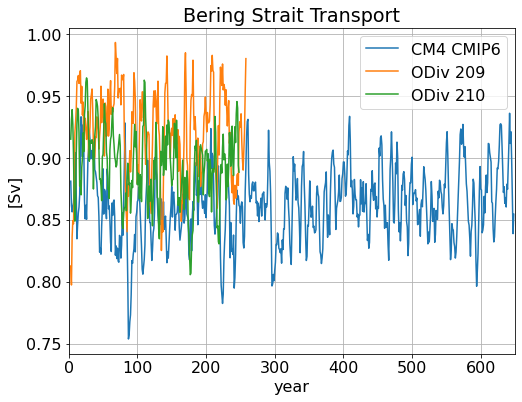

In [28]:
# Volume transport through Bering Strait
fig = plt.figure(figsize=(8,6))
(DS_cmip6pi.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='CM4 CMIP6')
(DS_o209.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 209')
(DS_o210.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 210')
plt.legend()
plt.title('Bering Strait Transport')
plt.ylabel('[Sv]')
plt.xlim(0,650)
plt.grid()
plt.show()

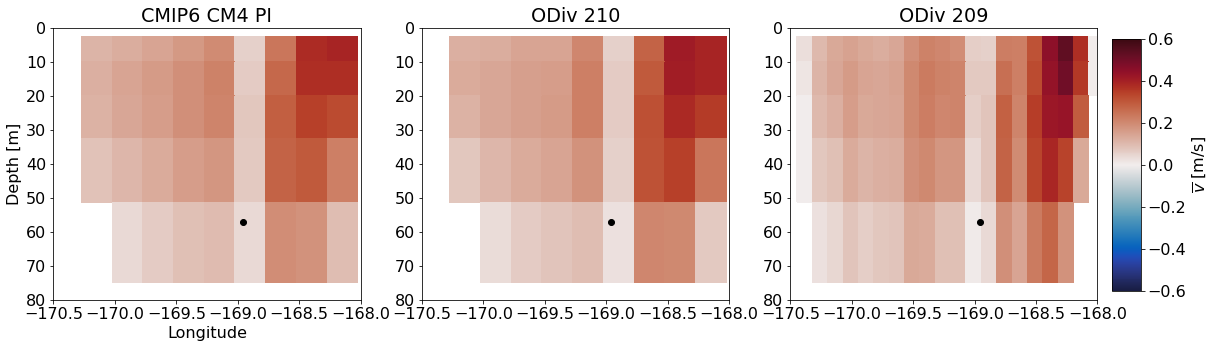

In [29]:
# Cross-sections of mean meridional velocity
vlim = 0.6
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon_v,DS_cmip6pi.z_l,DS_cmip6pi.vo.mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 210
ax1.pcolormesh(DS_o210.geolon_v,DS_o210.z_l,DS_o210.vo.mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 210')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon_v,DS_o209.z_l,DS_o209.vo.mean('time'),
                    cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{v}$ [m/s]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_meanXZsection_modelPI.pdf')

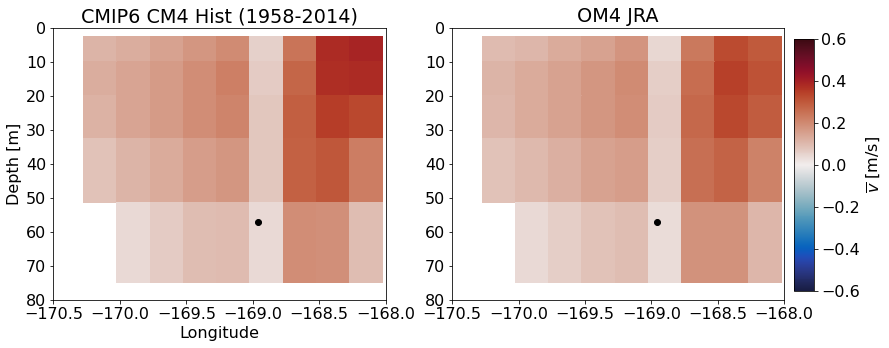

In [30]:
# Cross-sections of mean meridional velocity
vlim = 0.6
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6hi.geolon_v,DS_cmip6hi.z_l,
               DS_cmip6hi.vo.sel(time=slice('1958','2014')).mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 Hist (1958-2014)')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# OM4
im = ax1.pcolormesh(DS_om4.geolon_v,DS_om4.z_l,
                    DS_om4.vo.sel(time=slice('1958','2014')).mean('time'),
                    cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('OM4 JRA')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{v}$ [m/s]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_meanXZsection_modelHist.pdf')

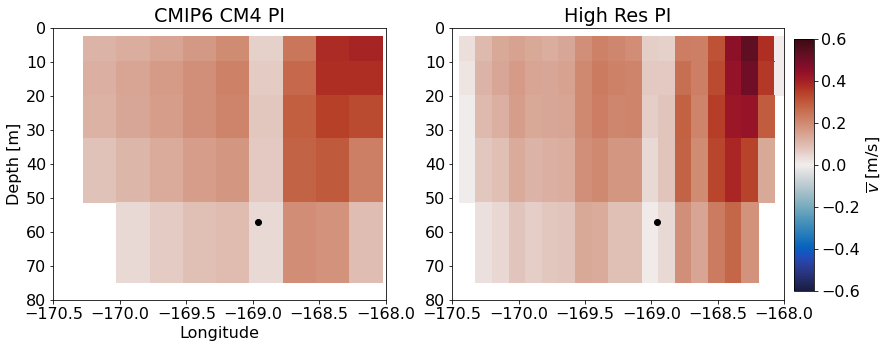

In [31]:
# Cross-sections of mean meridional velocity
vlim = 0.6
fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon_v,DS_cmip6pi.z_l,DS_cmip6pi.vo.mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon_v,DS_o209.z_l,DS_o209.vo.mean('time'),
                    cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('High Res PI')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{v}$ [m/s]')
plt.show()
# save fig
# fig.savefig('../figures/BeringStraitMooring/vo_meanXZsection_2modelPI.pdf')

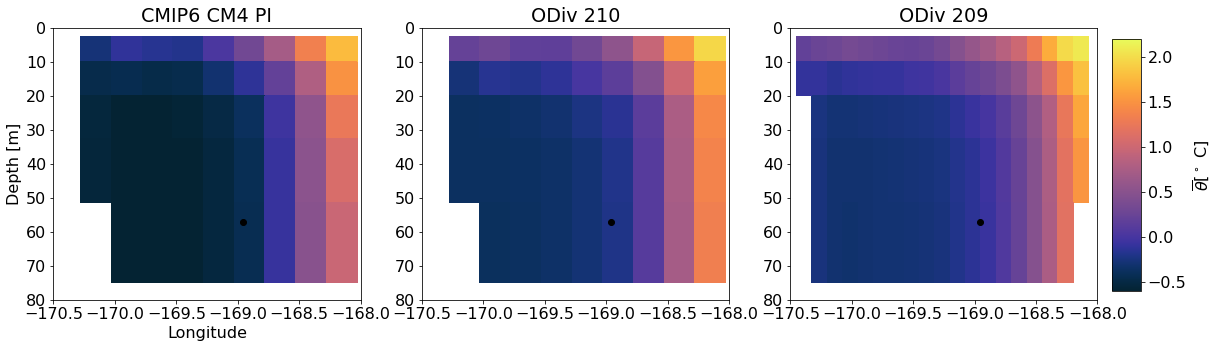

In [32]:
# Cross-sections of mean temperature
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.thetao.mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 210
ax1.pcolormesh(DS_o210.geolon,DS_o210.z_l,DS_o210.thetao.mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 210')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.thetao.mean('time'),
                    cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel(r'$\overline{\theta} [^\circ$ C]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/thetao_meanXZsection_modelPI.pdf')

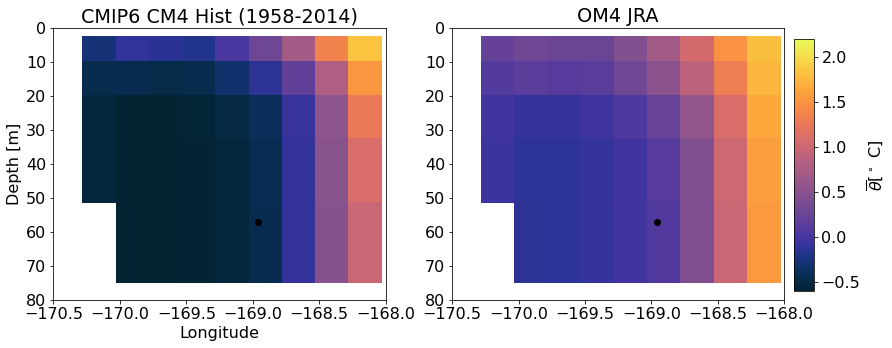

In [33]:
# Cross-sections of mean temperature
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6hi.geolon,DS_cmip6hi.z_l,
               DS_cmip6hi.thetao.sel(time=slice('1958','2014')).mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 Hist (1958-2014)')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# OM4
im = ax1.pcolormesh(DS_om4.geolon,DS_om4.z_l,
                    DS_om4.thetao.sel(time=slice('1958','2014')).mean('time'),
                    cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('OM4 JRA')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel(r'$\overline{\theta} [^\circ$ C]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/thetao_meanXZsection_modelHist.pdf')

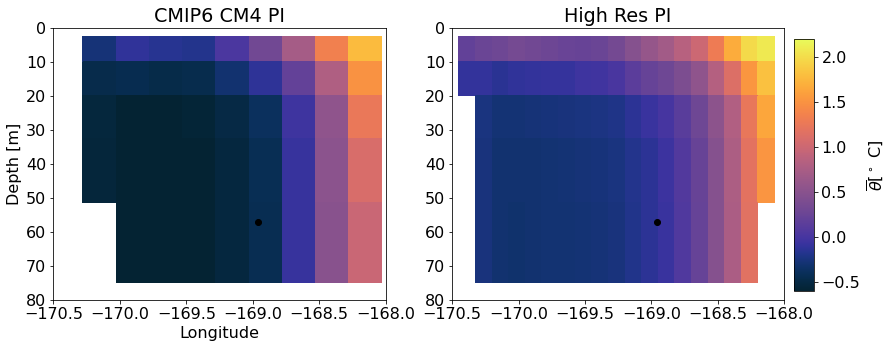

In [34]:
# Cross-sections of mean temperature
fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.thetao.mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.thetao.mean('time'),
                    cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('High Res PI')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel(r'$\overline{\theta} [^\circ$ C]')
plt.show()
# save fig
# fig.savefig('../figures/BeringStraitMooring/thetao_meanXZsection_2modelPI.pdf')

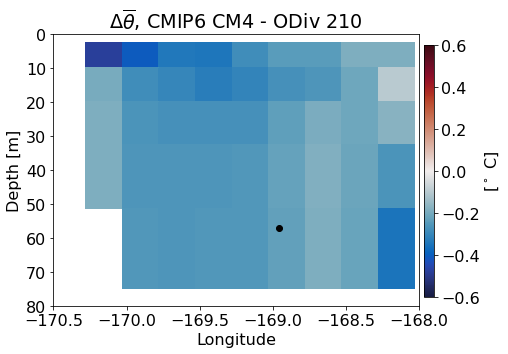

In [35]:
# Difference in Cross-sections of mean temperature for ODiv 209 and 1
fig, (ax0) = plt.subplots(1, 1, figsize=(7,5))
im = ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.thetao.mean('time') - DS_o210.thetao.mean('time'),
                    cmap='cmo.balance',vmin=-0.6,vmax=0.6)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title(r'$\Delta \overline{\theta}$, CMIP6 CM4 - ODiv 210')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('[$^\circ$ C]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/dthetao_meanXZsection_CMIP6CM4ODiv210.pdf')

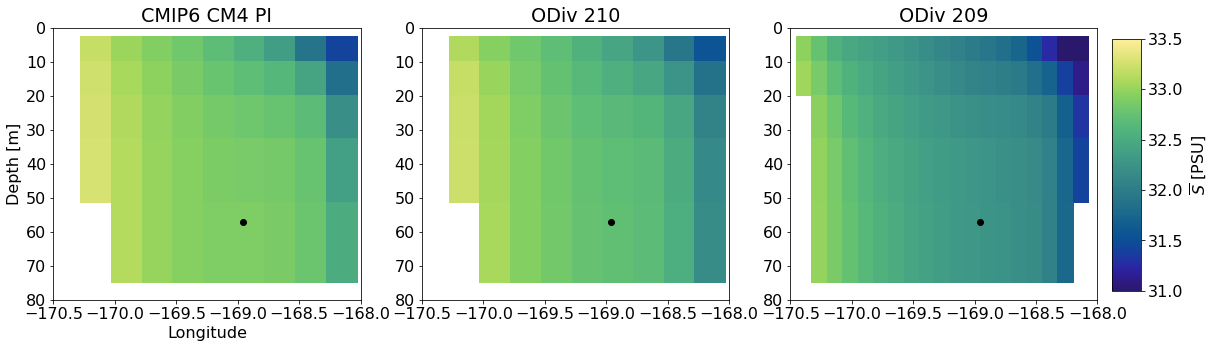

In [36]:
# Cross-sections of mean salinity
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.so.mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 210
ax1.pcolormesh(DS_o210.geolon,DS_o210.z_l,DS_o210.so.mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 210')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.so.mean('time'),
                    cmap='cmo.haline',vmin=31,vmax=33.5)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{S}$ [PSU]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/so_meanXZsection_modelPI.pdf')

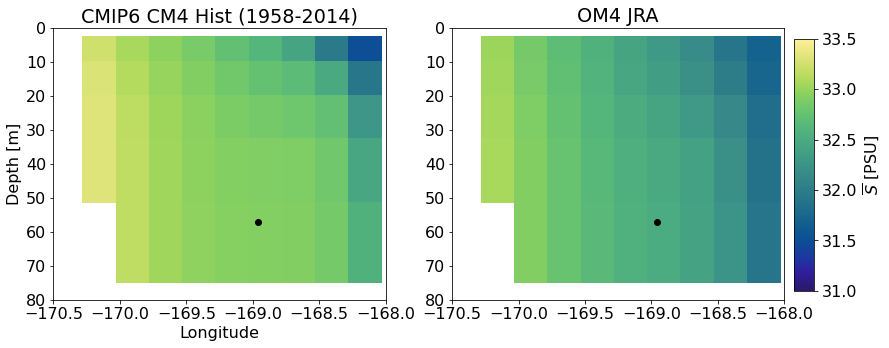

In [37]:
# Cross-sections of mean salinity
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6hi.geolon,DS_cmip6hi.z_l,
               DS_cmip6hi.so.sel(time=slice('1958','2014')).mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 Hist (1958-2014)')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# OM4
im = ax1.pcolormesh(DS_om4.geolon,DS_om4.z_l,
                    DS_om4.so.sel(time=slice('1958','2014')).mean('time'),
                    cmap='cmo.haline',vmin=31,vmax=33.5)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('OM4 JRA')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{S}$ [PSU]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/so_meanXZsection_modelHist.pdf')

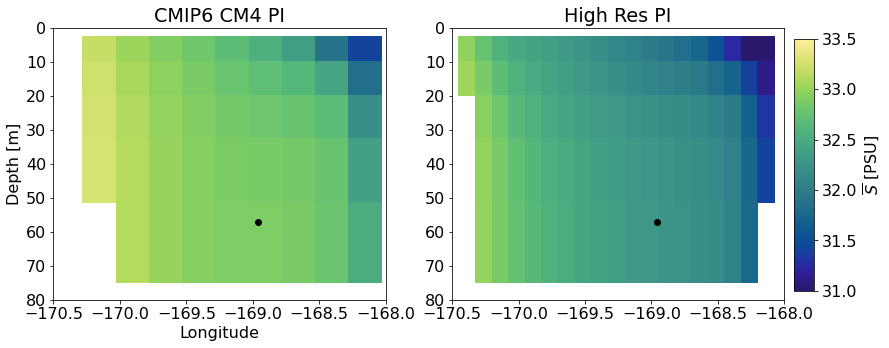

In [38]:
# Cross-sections of mean salinity
fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(14,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.so.mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.so.mean('time'),
                    cmap='cmo.haline',vmin=31,vmax=33.5)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('High Res PI')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{S}$ [PSU]')
plt.show()
# save fig
# fig.savefig('../figures/BeringStraitMooring/so_meanXZsection_2modelPI.pdf')

## Set observational paths

In [39]:
# Volume transport
fname_T = '../data/BeringStraitMooring/BeringStrait_Annualmeans_TRANSPORT_Jan2021.txt'
# Heat flux
fname_H = '../data/BeringStraitMooring/BeringStrait_Annualmeans_HEAT_Jan2021.txt'
# Freshwater flux
fname_F = '../data/BeringStraitMooring/BeringStrait_Annualmeans_FW_Jan2021.txt'

## Read in observational data

In [40]:
# Volume transport
BST = np.loadtxt(fname_T, comments='%')
# Heat flux
BSH = np.loadtxt(fname_H, comments='%')
# Freshwater flux
BSF = np.loadtxt(fname_F, comments='%')

## Make observational time series

In [41]:
# Make time array
time = xr.cftime_range(start=BST[0,0].astype('int').astype('str'), periods=BST.shape[0], freq="A-JUN", calendar="noleap")

In [42]:
# Volume transport
T_vol  = BST[:,-2] + 0.1
T_volE = BST[:,-1]

In [43]:
# Heat transport
T_heat  = (BSH[:,-2] + BSH[:,-1])/2
T_heatE = BSH[:,5]

In [44]:
# Freshwater transport
T_fresh  = (BSF[:,-2] + BSF[:,-1])/2
T_freshE = BSF[:,5]

## Check the Berring Strait cross-sectional area for each simulation

In [45]:
# CMIP6 CM4
area_cmip6 = (DS_cmip6pi.volcello.sum('z_l')/DS_cmip6pi.dyCv).sum('xh').mean('time').values
# HighRes CM4
area_hres = (DS_o209.volcello.sum('z_l')/DS_o209.dyCv).sum('xh').mean('time').values
# OM4
area_om4 = (DS_om4.volcello.sum('z_l')/DS_om4.dyCv).sum('xh').mean('time').values

In [46]:
print('Bering Strait cross-sectional area [m^3]')
print('Observations: %i' %area_BS)
print('   CMIP6 CM4: %i' %area_cmip6)
print(' HighRes CM4: %i' %area_hres)
print('     JRA OM4: %i' %area_om4)

Bering Strait cross-sectional area [m^3]
Observations: 4250000
   CMIP6 CM4: 4679148
 HighRes CM4: 4818585
     JRA OM4: 4691019


In [47]:
print('Simulated Bering Strait frational cross-sectional area')
print('  CMIP6 CM4: %.3f' %(area_cmip6/area_BS))
print('HighRes CM4: %.3f' %(area_hres/area_BS))
print('    JRA OM4: %.3f' %(area_om4/area_BS))

Simulated Bering Strait frational cross-sectional area
  CMIP6 CM4: 1.101
HighRes CM4: 1.134
    JRA OM4: 1.104


## Define transport and flux calcs

In [48]:
def calc_Bering_daily(DS):
    # Model reference density [kg/m3]
    rho_0 = 1035
    # Reference potential temperature for heat flux [deg C]
    theta_ref = -1.9
    # Heat capacity of water for model output [J/kg K]
    C_p = 3992
    # Reference salinity for freshwater flux [PSU]
    S_ref = 34.8
    # Lat, Lon, depth of mooring observations
    llz = [66 + (19.6/60), -168 - (57.5/60), 57]
    # Cross-sectional area of strait [m^2]
    area_BS = 4.25e6
    
    # Volume transport [m3/s]
    DS['T_vol'] = DS.vmo/rho_0
    
    # Volume from mooring method [m3/s]
    DS['T_volM'] = DS.vo.isel(xh=abs(DS.geolon_v - llz[1]).argmin()
                             ).sel(z_l=llz[-1],method='nearest').chunk(
        {'time':300000}) * area_BS + 1e5
    
    # Volume from mooring method using depth average [m3/s]
    DS['T_volMz'] = DS.vo.sel(z_l=llz[-1],method='nearest'
                             ).mean('xh').chunk({'time':300000}) * area_BS + 1e5
    
    # Heat flux [J/s]
    DS['F_heat'] = rho_0 * DS.T_vol * C_p * (DS.thetao - theta_ref)
    
    # Heat transport [J]
    DS['T_heat'] = DS.F_heat * 86400
    
    # Heat flux from mooring method [J/s]
    DS['F_heatM'] = rho_0 * DS.T_volMz * C_p * (
        DS.thetao.isel(xh=abs(DS.geolon_v - llz[1]).argmin()
                      ).sel(z_l=llz[-1],method='nearest'
                           ).chunk({'time':300000}) - theta_ref)
    
    # Heat transport from mooring method [J]
    DS['T_heatM'] = DS.F_heatM * 86400
    
    # Freshwater flux [km3/s]
    DS['F_fresh'] = DS.T_vol * (1 - (DS.so/S_ref)) * (10**-9)
    
    # Fresh water transport [km3]
    DS['T_fresh'] = DS.F_fresh * 86400
    
    # Freshwater flux using the mooring method [km3/s]
    DS['F_freshM'] = DS.T_volMz * (1 - (DS.so.isel(
        xh=abs(DS.geolon_v - llz[1]).argmin()).sel(
        z_l=llz[-1],method='nearest').chunk({'time':300000})/S_ref)) * (10**-9)

    # Fresh water transport using the moorning method [km3]
    DS['T_freshM'] = DS.F_freshM * 86400
    return DS

## Calc volume transport, heat flux, and freshwater flux

In [49]:
# CMIP6 CM4 pi
_ = calc_Bering_daily(DS_cmip6pi)

In [50]:
# CMIP6 CM4 historical
_ = calc_Bering_daily(DS_cmip6hi)

In [51]:
# ODIV209 CM4
_ = calc_Bering_daily(DS_o209)

In [52]:
# ODIV210 CM4
_ = calc_Bering_daily(DS_o210)

In [53]:
# OM4
_ = calc_Bering_daily(DS_om4)

## Plot historical run with observations

In [54]:
# Make model time series
T = (DS_cmip6hi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
Tm = (DS_cmip6hi.T_volM*(10**-6)).groupby('time.year').mean()
Tz = (DS_cmip6hi.T_volMz*(10**-6)).groupby('time.year').mean()
H = (DS_cmip6hi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
Hm = (DS_cmip6hi.T_heatM*(10**-20)).groupby('time.year').sum()
F = DS_cmip6hi.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum()
Fm = DS_cmip6hi.T_freshM.groupby('time.year').sum()

In [55]:
# Make model time series
T_om4 = (DS_om4.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
H_om4 = (DS_om4.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
F_om4 = DS_om4.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum()

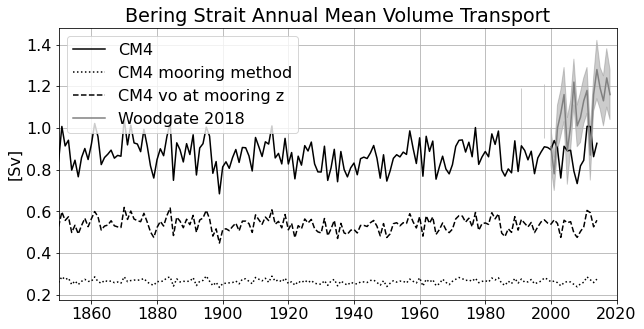

In [56]:
# Volume transport from different mooring methods
fig = plt.figure(figsize=(10,5))
plt.plot(T.year,T,'k',label = 'CM4')
plt.plot(Tm.year,Tm,':k',label = 'CM4 mooring method')
plt.plot(Tz.year,Tz,'--k',label = 'CM4 vo at mooring z')
plt.fill_between(time.year,T_vol-T_volE,T_vol+T_volE,color='grey',alpha=0.4)
plt.plot(time.year,T_vol,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Mean Volume Transport')
plt.ylabel('[Sv]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()

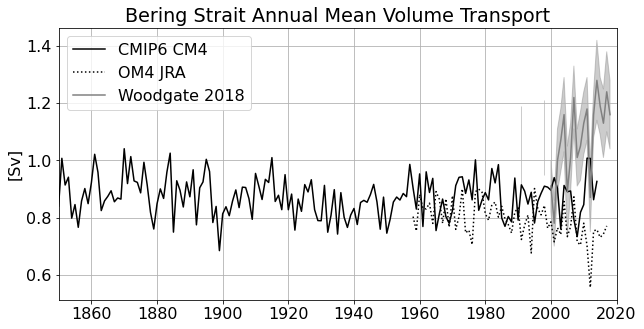

In [57]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(T.year,T,'k',label = 'CMIP6 CM4')
plt.plot(T_om4.year,T_om4,':k',label = 'OM4 JRA')
plt.fill_between(time.year,T_vol-T_volE,T_vol+T_volE,color='grey',alpha=0.4)
plt.plot(time.year,T_vol,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Mean Volume Transport')
plt.ylabel('[Sv]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_annual_modelHistObs.pdf')

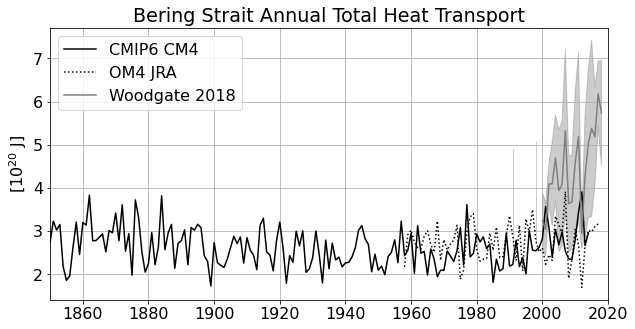

In [58]:
# Heat transport
fig = plt.figure(figsize=(10,5))
plt.plot(H.year,H,'k',label = 'CMIP6 CM4')
plt.plot(H_om4.year,H_om4,':k',label = 'OM4 JRA')
plt.fill_between(time.year,T_heat-T_heatE,T_heat+T_heatE,color='grey',alpha=0.4)
plt.plot(time.year,T_heat,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Heat Transport')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Theat_annual_modelHistObs.pdf')

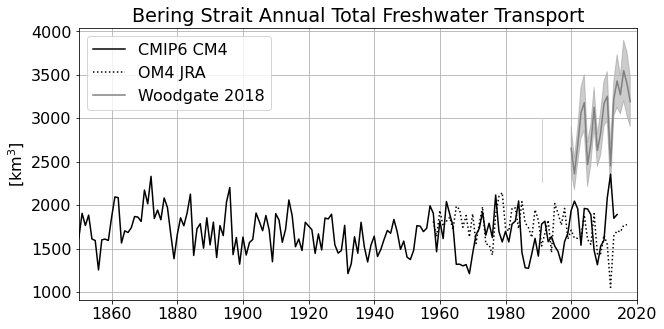

In [59]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
plt.plot(F.year,F,'k',label = 'CMIP6 CM4')
plt.plot(F_om4.year,F_om4,':k',label = 'OM4 JRA')
plt.fill_between(time.year,T_fresh-T_freshE,T_fresh+T_freshE,color='grey',alpha=0.4)
plt.plot(time.year,T_fresh,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Freshwater Transport')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tfresh_annual_modelHistObs.pdf')

## Plot PI runs with observation statistics

In [60]:
# Observation stats
# Volume
T_bar = np.nanmean(T_vol)
T_err = np.nanmean(T_volE)
# Heat
H_bar = np.nanmean(T_heat)
H_err = np.nanmean(T_heatE)
# Freshwater
F_bar = np.nanmean(T_fresh)
F_err = np.nanmean(T_freshE)

In [61]:
# Make model volume transport timeseries
T_cm4 = (DS_cmip6pi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
T_o209 = (DS_o209.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
T_o210 = (DS_o210.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

In [62]:
T_cm4STs = (DS_cmip6pi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
T_hiSTs = (DS_cmip6hi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
T_o209STs = (DS_o209.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
T_o210STs = (DS_o210.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
T_om4STs = (DS_om4.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
# Print out stats for table
print('Bering Strait Annual Mean Volume Transport [Sv]')
print('Observations: %.2f +/- %.2f' % (T_bar, T_err))
print('CMIP6 CM4 PI: %.2f +/- %.2f' % (T_cm4STs.mean(), T_cm4STs.std()))
print('CMIP6 CM4 Hi: %.2f +/- %.2f' % (T_hiSTs.mean(), T_hiSTs.std()))
print('    ODiv 209: %.2f +/- %.2f' % (T_o209STs.mean(), T_o209STs.std()))
print('    ODiv 210: %.2f +/- %.2f' % (T_o210STs.mean(), T_o210STs.std()))
print('  OM4 JRA Hi: %.2f +/- %.2f' % (T_om4STs.mean(), T_om4STs.std()))

Bering Strait Annual Mean Volume Transport [Sv]
Observations: 1.07 +/- 0.12
CMIP6 CM4 PI: 0.86 +/- 0.06
CMIP6 CM4 Hi: 0.87 +/- 0.07
    ODiv 209: 0.92 +/- 0.08
    ODiv 210: 0.89 +/- 0.07
  OM4 JRA Hi: 0.79 +/- 0.07


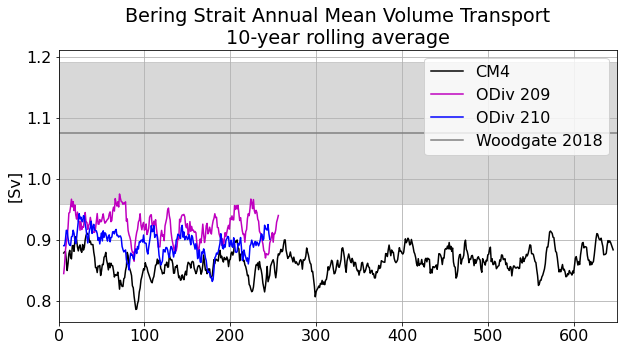

In [63]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(T_cm4.year,T_cm4,'k',label = 'CM4')
plt.plot(T_o209.year,T_o209,'m',label = 'ODiv 209')
plt.plot(T_o210.year,T_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[T_bar-T_err, T_bar-T_err],[T_bar+T_err, T_bar+T_err],color='grey',alpha=0.3)
plt.plot([0, 650],[T_bar, T_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_annual_modelPIObs.pdf')

In [64]:
# Make model heat transport timeseries
H_cm4 = (DS_cmip6pi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
H_o209 = (DS_o209.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
H_o210 = (DS_o210.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

In [65]:
H_cm4STs = (DS_cmip6pi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
H_hiSTs = (DS_cmip6hi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
H_o209STs = (DS_o209.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
H_o210STs = (DS_o210.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
H_om4STs = (DS_om4.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
# Print out stats for table
print('Bering Strait Annual Total Heat Transport [10^20 J]')
print('Observations: %.2f +/- %.2f' % (H_bar, H_err))
print('CMIP6 CM4 PI: %.2f +/- %.2f' % (H_cm4STs.mean(), H_cm4STs.std()))
print('CMIP6 CM4 Hi: %.2f +/- %.2f' % (H_hiSTs.mean(), H_hiSTs.std()))
print('    ODiv 209: %.2f +/- %.2f' % (H_o209STs.mean(), H_o209STs.std()))
print('    ODiv 210: %.2f +/- %.2f' % (H_o210STs.mean(), H_o210STs.std()))
print('  OM4 JRA Hi: %.2f +/- %.2f' % (H_om4STs.mean(), H_om4STs.std()))

Bering Strait Annual Total Heat Transport [10^20 J]
Observations: 4.38 +/- 1.20
CMIP6 CM4 PI: 2.57 +/- 0.40
CMIP6 CM4 Hi: 2.63 +/- 0.45
    ODiv 209: 3.07 +/- 0.47
    ODiv 210: 3.00 +/- 0.45
  OM4 JRA Hi: 2.75 +/- 0.43


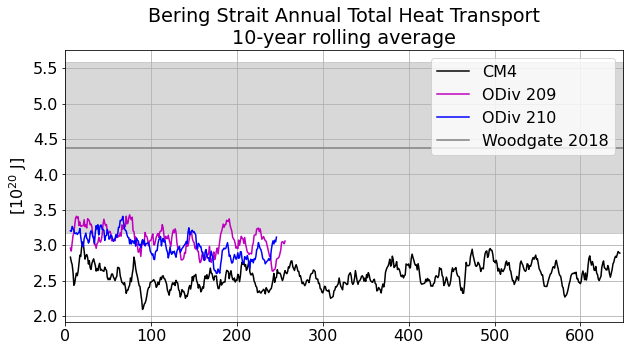

In [66]:
# Heat transport
fig = plt.figure(figsize=(10,5))
plt.plot(H_cm4.year,H_cm4,'k',label = 'CM4')
plt.plot(H_o209.year,H_o209,'m',label = 'ODiv 209')
plt.plot(H_o210.year,H_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[H_bar-H_err, H_bar-H_err],[H_bar+H_err, H_bar+H_err],color='grey',alpha=0.3)
plt.plot([0, 650],[H_bar, H_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Theat_annual_modelPIObs.pdf')

In [67]:
# Make model heat transport timeseries
F_cm4 = DS_cmip6pi.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
F_o209 = DS_o209.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
F_o210 = DS_o210.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

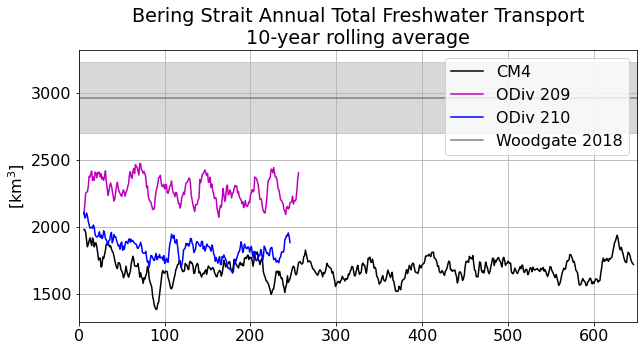

In [68]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
plt.plot(F_cm4.year,F_cm4,'k',label = 'CM4')
plt.plot(F_o209.year,F_o209,'m',label = 'ODiv 209')
plt.plot(F_o210.year,F_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[F_bar-F_err, F_bar-F_err],[F_bar+F_err, F_bar+F_err],color='grey',alpha=0.3)
plt.plot([0, 650],[F_bar, F_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tfresh_annual_modelPIObs.pdf')